## Setup y lectura de datos

In [1]:
# instalamos Prophet
!pip install fbprophet

In [2]:
from fbprophet import Prophet
import pandas as pd
import numpy as np

In [3]:
# leemos los datos
sales_train_df = pd.read_csv("/content/drive/MyDrive/Blog Notion/train.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



## Descripción de los datos

Un resumen del dataset:
* 1115 tiendas únicas 
* Id:  ID de transacción (combinación de la tienda y la fecha)
* Store: identificador único de la tienda
* Sales: ventas diarias, esta es la variable objetivo
* Customers: número de clientes de un día dado
* Open: Booleano para indicar si la tienda estaba abierta o cerrada (0 = cerrada, 1 = abierta)
* Promo: describe si la tienda tenía algún tipo de promoción ese día o no
* StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua, c = Navidades, 0 = No era festivo)
* SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas

In [4]:
sales_train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## Preprocesamiento de datos

In [5]:
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [6]:
# Obtenemos todas las fechas relacionadas a vacaciones escolares
school_holidays = sales_train_df[sales_train_df['SchoolHoliday'] == 1].loc[:,'Date'].values
school_holidays.shape

(163457,)

In [8]:
school_holidays = np.unique(school_holidays)
school_holidays.shape

(477,)

In [9]:
# Obtenemos todas las fechas relacionadas a vacaciones estatales
state_holidays = sales_train_df[(sales_train_df['StateHoliday'] == 'a') | (sales_train_df['StateHoliday'] == 'b') | (sales_train_df['StateHoliday'] == 'c')].loc[:,'Date'].values
state_holidays.shape

(910,)

In [10]:
state_holidays = np.unique(state_holidays)
state_holidays.shape

(35,)

In [11]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays), 'holiday': 'school_holiday'})

In [12]:
school_holidays

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-02,school_holiday
2,2013-01-03,school_holiday
3,2013-01-04,school_holiday
4,2013-01-05,school_holiday
...,...,...
472,2015-07-27,school_holiday
473,2015-07-28,school_holiday
474,2015-07-29,school_holiday
475,2015-07-30,school_holiday


In [13]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays), 'holiday': 'state_holiday'})

In [14]:
state_holidays

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-06,state_holiday
2,2013-03-29,state_holiday
3,2013-04-01,state_holiday
4,2013-05-01,state_holiday
5,2013-05-09,state_holiday
6,2013-05-20,state_holiday
7,2013-05-30,state_holiday
8,2013-08-15,state_holiday
9,2013-10-03,state_holiday


In [15]:
all_holidays = pd.concat((school_holidays, state_holidays), axis=0)

In [16]:
all_holidays

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-02,school_holiday
2,2013-01-03,school_holiday
3,2013-01-04,school_holiday
4,2013-01-05,school_holiday
...,...,...
30,2015-04-06,state_holiday
31,2015-05-01,state_holiday
32,2015-05-14,state_holiday
33,2015-05-25,state_holiday


## Pronóstico

Primero vamos a definir una función que recibirá como parámtetros: el dataframe, el ID de sucursal y el número de periodos que queremos pronosticar.

In [17]:
def sales_predictions(df, id, periods, vacations):
	# Seleccionamos los datos de la tienda que nos interesa
  df = df[df['Store'] == id]

	# Renombramos los campos para que Prophet no tenga problemas
  df = df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})

	# Ordenamos por fecha
  df = df.sort_values('ds')

	# En caso de haberle pasado vacaciones Prophet las recibe
  model = Prophet(holidays = vacations)

	# Ajuste del modelo a los datos
  model.fit(df)
	
	# Número de periodos que queremos predecir
  future = model.make_future_dataframe(periods = periods)

	# El modelo calcula las predicciones
  forecast = model.predict(future)

	# Graficamos las predicciones
  figure = model.plot(forecast, xlabel = "Fecha", ylabel = "Ventas")

	# Graficamos los componentes: tendencia, efecto semanal, efecto anual y efecto de vacaciones
  figure2 = model.plot_components(forecast)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


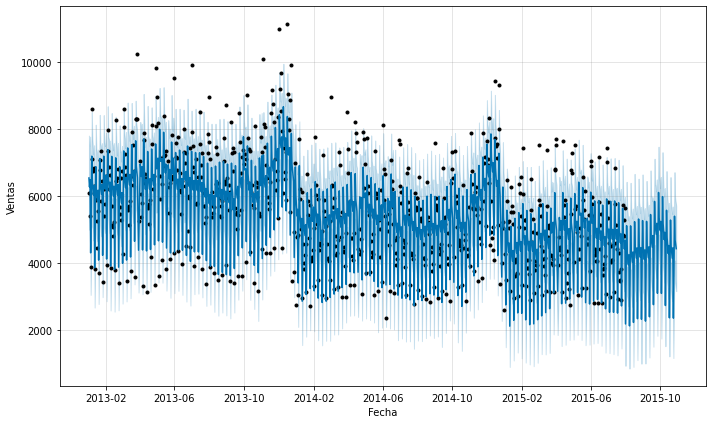

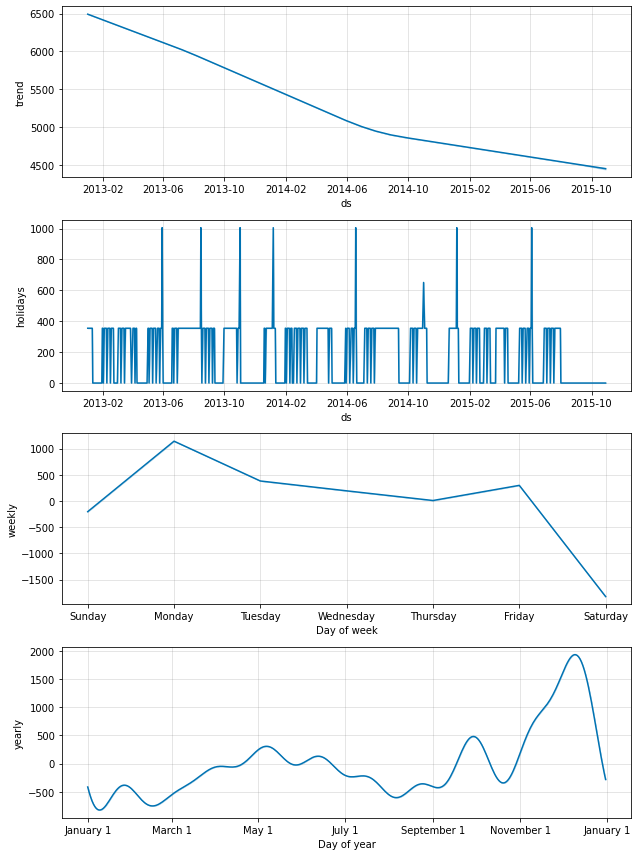

In [23]:
sales_predictions(sales_train_df, 6, 90, all_holidays)